# Replication of Nath 2021 on 2022 task 2 data

In [1]:
# Other packages 

import pandas as pd
import numpy as np
import os
import config

# Tensorflow

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Dense, Embedding, LSTM
from tensorflow.keras.layers import Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import Constant
from tensorflow.keras.utils import Sequence, plot_model

# Set seed
# Won't replicate with all seeds, Nath uses no seed

tf.random.set_seed(8)
np.random.seed(8)

In [1]:
#### Download GloveEmbeddings

# - The following code chunk can be used to download the word embeddings, and extracts the correct file from the zip
# - Is included in gitignore so will be kept on your computer

#import urllib.request
#import shutil
#import zipfile
#urllib.request.urlretrieve('http://nlp.stanford.edu/data/glove.6B.zip', 'glove.6B.zip')
#shutil.move(config.base_dir+'glove.6B.zip', config.base_dir+'embeddings/glove.6B.zip')
#with zipfile.ZipFile(config.base_dir+'embeddings/glove.6B.zip', 'r') as zfile:
#    unpacked = open(config.base_dir+'embeddings/glove.6B.50d.txt', 'w')
#    unpacked.write(zfile.read('glove.6B.50d.txt').decode('utf-8'))
#    unpacked.close()

## Functions

### Data prep

In [2]:
# https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly

class DataGeneratorSiamese(Sequence):
    """
    Data Generator for the Koppel Blog Corpus for the Baseline_using_MGBD notebook.
    """
    'Generates data for keras'
    def __init__(self, df, tokenizer, max_len=300,  batch_size= 32, num_clases = 2, shuffle = False):
        #self.file = file
        self.max_len = max_len
        self.batch_size = batch_size
        self.df = df #pd.read_csv(open(file))
        self.indices = self.df.index.to_list()
        self.num_classes = num_clases
        self.shuffle = shuffle
        self.tokenizer = tokenizer

        #self.on_epoch_end()

    def __len__(self):
        return len(self.indices)//self.batch_size

    def __getitem__(self, index):
        # Generate one batch of data
        # Generate indices of the batch
        index = self.index[index * self.batch_size:(index + 1) * self.batch_size]  # Select the list of IDs to return as batch
        batch = [self.indices[k] for k in index]  # Generate data
        X, y = self.__get_data(batch)
        return X, y

    def on_epoch_end(self):
        self.index = np.arange(len(self.indices))
        if self.shuffle == True:
            np.random.shuffle(self.index)

    def __get_data(self, batch):
        """
        This function gets a list of selected indices to form selected batch. A transformation is performed to create X and Y.
        X is the cosine similarity between the embedded paragraphs P1 and P2.
        :param batch: selected indices for df
        :return: batch of data
        """
        # == signifies, same author, != signifies diff author. flipping to observe the difference if any
        y = ((self.df.loc[batch]['author_1'] != self.df.loc[batch]['author_2']).astype(int)).to_numpy() # labels
        p1_column = self.df.loc[batch]['para1_text'].values
        p2_column = self.df.loc[batch]['para2_text'].values
        p1_embed = self.tokenizer.texts_to_sequences(p1_column)
        p2_embed = self.tokenizer.texts_to_sequences(p2_column)
        p1_embed = pad_sequences(p1_embed, maxlen=self.max_len, padding='post')
        p2_embed = pad_sequences(p2_embed, maxlen=self.max_len, padding='post')
        #print(p1_embed[0].shape, p2_embed[0].shape)
        #X = np.array([np.squeeze(cosine_similarity([p1_embed[i]], [p2_embed[i]])) for i in range(len(p1_embed))]) # cosine_similarity(p1_embed, p2_embed)
        #print(X.shape)
        # to_categorical(y, num_classes=self.num_classes)
        return [p1_embed, p2_embed], y

### Tokenizers

In [4]:
def get_tokenizer(training_data, max_words):
    combined = training_data["para1_text"] + " " + training_data["para2_text"]
    tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
    tokenizer.fit_on_texts(combined.values)
    return tokenizer

def get_embed_matrix(tokenizer, embedding_dim):
    embeddings_index = {}
    f = open(config.config_io.get("embedding")) 
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    f.close()
    print('Found %s word vectors.' % len(embeddings_index))
    embed_matrix = get_glove_embed_matrix(tokenizer, embeddings_index, embedding_vector_size = embedding_dim)
    print(embed_matrix.shape)  
    return embed_matrix

def get_glove_embed_matrix(t, embeddings_index, embedding_vector_size = 50):
    """
    t: tokenizer

    """
    not_present_list = []
    vocab_size = len(t.word_index) + 1
    embedding_matrix = np.zeros((vocab_size, len(embeddings_index['no'])))
    for word, i in t.word_index.items():
        embedding_vector = None
        if word in embeddings_index.keys():
            embedding_vector = embeddings_index.get(word)
        else:
            not_present_list.append(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
        else:
            embedding_matrix[i] = np.zeros(embedding_vector_size) # size of the embedding
    print('Loaded %s word vectors.' % len(embeddings_index))
    return embedding_matrix    

### Distance measures

In [5]:
def exponent_neg_cosine_distance(left,right):
    left = tf.keras.backend.l2_normalize(left, axis=-1)
    right = tf.keras.backend.l2_normalize(right, axis=-1)
    return tf.keras.backend.exp(tf.keras.backend.sum(tf.keras.backend.prod([left, right], axis=0), axis=1, keepdims=True))

## Modelling LSTM 2022

### Load data

In [6]:
# Load and check

training_data = pd.read_csv(config.processed_datasets['train_2022_task2'])
training_data.head()

,problem,author_1,author_2,para1_text,para2_text
0,problem-1734.txt,1,2,Only if you notice sites breaking on you. It ...,I have always believed that passing any test i...
1,problem-1734.txt,2,3,I have always believed that passing any test i...,No. Acid3 is a goal or benchmark for browsers;...
2,problem-1734.txt,3,2,No. Acid3 is a goal or benchmark for browsers;...,"FWIW, my copy of FireFox scores 72/100 which i..."
3,problem-1734.txt,2,4,"FWIW, my copy of FireFox scores 72/100 which i...","No, your browser passing the Acid 3 test isn't..."
4,problem-3123.txt,1,2,You can simply force redirection on default we...,The old trick to just redirect the Default Web...


### Setup tokenization and embedding

In [7]:
# Settings

MAX_WORDS = 10000
MAX_LEN = 300
EMBEDDING_DIM = 50

# Tokenizer

tokenizer = get_tokenizer(training_data, max_words=MAX_WORDS)

# Embedding matrix

embed_matrix = get_embed_matrix(tokenizer, embedding_dim=EMBEDDING_DIM)

Found 400000 word vectors.
Loaded 400000 word vectors.
(45360, 50)


### Setup data generation + make a validation split

In [8]:
# Setup data

len_train = len(training_data)
BATCH_SIZE = 64
TRAINING_PROP = 0.8

# "Generate" data: Nath (2021)

training_generator = DataGeneratorSiamese(training_data.iloc[0:int(0.8*len_train)], tokenizer=tokenizer,max_len=MAX_LEN, batch_size=BATCH_SIZE)
validation_generator = DataGeneratorSiamese(training_data.iloc[int(0.8*len_train):], tokenizer=tokenizer, max_len=MAX_LEN, batch_size=BATCH_SIZE)
training_generator.on_epoch_end() # this is a hack for "'DataGenerator' object has no attribute 'index'". 
validation_generator.on_epoch_end() # this is a hack for "'DataGenerator' object has no attribute 'index'". 

### Define model (LSTM)

- The author might have been inspired here: https://github.com/fionn-mac/Manhattan-LSTM

In [9]:
# Define model architecture

def create_model(max_len, tokenizer, embed_matrix, embedding_dim, optimizer):
    input_1 = Input(shape=(max_len,))#(train_p1_seq.shape[1],)
    input_2 = Input(shape=(max_len,))

    lstm_layer = Bidirectional(LSTM(50, dropout=0.2))
    embeddings_initializer = Constant(embed_matrix)
    emb =  Embedding(len(tokenizer.word_index)+1,
                     embedding_dim,
                     embeddings_initializer=embeddings_initializer,
                     input_length=max_len,
                     weights=[embed_matrix],
                     trainable=True)

    e1 = emb(input_1)
    x1 = lstm_layer(e1)

    e2 = emb(input_2)
    x2 = lstm_layer(e2)

    mhd = lambda x: exponent_neg_cosine_distance(x[0], x[1]) 
    merged = Lambda(function=mhd, output_shape=lambda x: x[0], name='cosine_distance')([x1, x2])
    preds = Dense(1, activation='sigmoid')(merged)
    model = Model(inputs=[input_1, input_2], outputs=preds)
    model.compile(loss = "binary_crossentropy",  metrics=['acc'], optimizer = optimizer)

    return model

### Model initialization and summary

In [10]:
# Optimizer set

opt = Adam(clipnorm=1.5) # Nath (2021)


In [11]:
model = create_model(max_len=MAX_LEN,
                     tokenizer=tokenizer, 
                     embed_matrix=embed_matrix,
                     embedding_dim=EMBEDDING_DIM,
                     optimizer=opt)

In [12]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 300)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 300)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 300, 50)      2268000     ['input_1[0][0]',                
                                                                  'input_2[0][0]']                
                                                                                                  
 bidirectional (Bidirectional)  (None, 100)          40400       ['embedding[0][0]',          

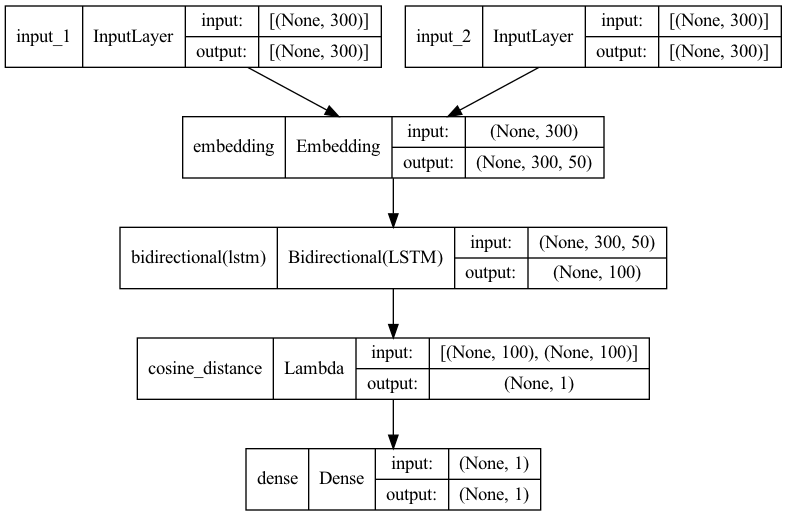

In [13]:
# Graphical plot of the network

plot_model(model, to_file='plots/model_lstm.png', show_shapes=True, show_layer_names=True)

### Checkpoints

In [14]:
# Checkpoints

checkpoint_path = config.checkpoints.get("bilstm_2022")
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    save_freq=5*BATCH_SIZE)

model.save_weights(checkpoint_path.format(epoch=0))

stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [15]:
# Fit
# We use shuffle = True because we don't know the seed of Nath (2021)

EPOCHS = 100 # Nath (2021): 60 epochs
STEPS_PER_EPOCH = 100 # Nath (2021): 100 epochs
SHUFFLE = True # Nath (2021): False

In [16]:
# Make it
history = model.fit(training_generator,
                    validation_data=validation_generator,
                    verbose=1,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    steps_per_epoch=STEPS_PER_EPOCH,
                    shuffle=SHUFFLE,
                    callbacks=[cp_callback,stop_callback])

2022-04-20 12:12:56.863501: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/100
100/100 [==============================] - 24s 208ms/step - loss: 0.7517 - acc: 0.4014 - val_loss: 0.7286 - val_acc: 0.3892
Epoch 2/100
100/100 [==============================] - 21s 213ms/step - loss: 0.7173 - acc: 0.3786 - val_loss: 0.7044 - val_acc: 0.4233
Epoch 3/100
100/100 [==============================] - 20s 197ms/step - loss: 0.6953 - acc: 0.4981 - val_loss: 0.6867 - val_acc: 0.5826
Epoch 4/100
 19/100 [====>.........................] - ETA: 12s - loss: 0.6842 - acc: 0.5987
Epoch 00004: saving model to /Users/asmusharre/Documents/GitHub/project-2022-group-4/checkpoints/training_bilstm_2022/cp-0004.ckpt
100/100 [==============================] - 21s 208ms/step - loss: 0.6811 - acc: 0.6123 - val_loss: 0.6770 - val_acc: 0.6196
Epoch 5/100
100/100 [==============================] - 20s 202ms/step - loss: 0.6720 - acc: 0.6327 - val_loss: 0.6719 - val_acc: 0.6108
Epoch 6/100
100/100 [==============================] - 21s 206ms/step - loss: 0.6699 - acc: 0.6108 - val_los

<AxesSubplot:>

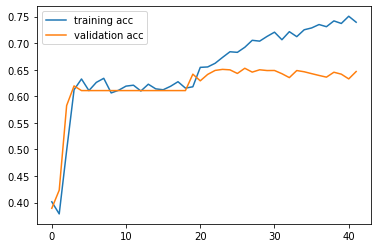

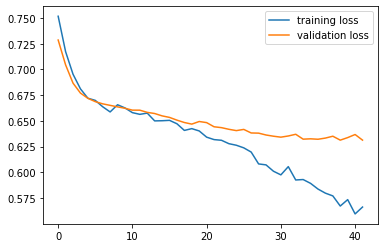

In [17]:
# Plots

acc = pd.DataFrame({"training acc":history.history['acc'],
                            "validation acc": history.history['val_acc']})
acc.plot()

loss = pd.DataFrame({"training loss":history.history['loss'],
                            "validation loss": history.history['val_loss']})
loss.plot()

In [18]:
# Save history to csv

history_path = config.history['bilstm_2022']
pd.DataFrame.from_dict(history.history).to_csv(history_path,index=False)

### "Test" error with the real validation set

In [20]:
testing_data = pd.read_csv(config.processed_datasets.get('valid_2022'))
testing_generator = DataGeneratorSiamese(testing_data, tokenizer=tokenizer, max_len=MAX_LEN, batch_size=BATCH_SIZE)
testing_generator.on_epoch_end()

test_loss, test_acc = model.evaluate(testing_generator)
test_loss, test_acc

33/33 [==============================] - 1s 31ms/step - loss: 0.7748 - acc: 0.5009


(0.7748434543609619, 0.5009469985961914)